#### Imports and settings

In [3]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import tensorflow

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json

%matplotlib inline
%load_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tensorflow.pywrap_tensorflow.IsMklEnabled())

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
Intel-optimized TensorFlow is enabled: True


#### Customize IDE (currently raw)

In [13]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

#### Load datasets and pretrained models

In [4]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

glove_model = f'{PRETRAINED_PATH}glove.6B.50d.txt'
train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')

### EDA (Exploratory data analysis)

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [9]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [10]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

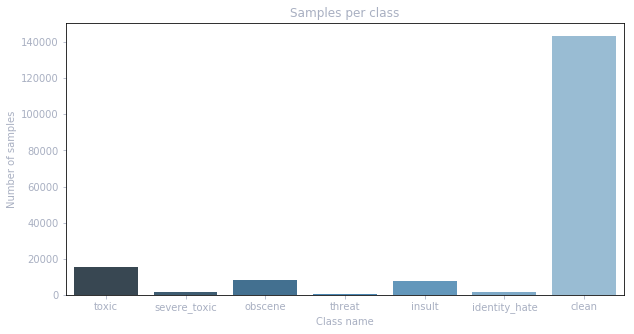

In [14]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

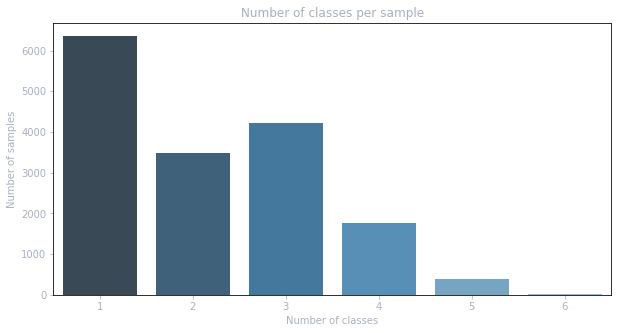

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [15]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [16]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [18]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [19]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> Where is the real vagina? 

The real photo of vagina is gone!

Would you mind if I make the new one?

The vagina picture is Indonesian's vagina. Do you love it?

 --- 

Severe toxic:

> hello 

will you suck my dick for $5? please reply

 --- 

Obscene:

> "

 What the fuck???? 

I am indignant, pissed, embarrassed, and humiliated.   Talk• Contributions "

 --- 

Threat:

> Stop being a shithead, or I will rip off your head and piss down your esophagus, mother fucker. We Came In?

 --- 

Insult:

> This idiot graceful slick needs a friend to touch his no no spot 172.56.34.4

 --- 

Identity hate:

> Jews 

Jews are fucking bastards. I hope neo nazis unite and holocaust the bastards again. Including jews like Tnxman309, Nawlinwiki, Pmdrive1061 and J.delanoy.

 --- 

Clean:

> Sorry about the edit conflict; I'm glad you were able to salvage my edits. As to your question about structuring, yes I think we will have to think of a way to divide the article into sections and subsect

#### Wordclouds

In [20]:
stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))

wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

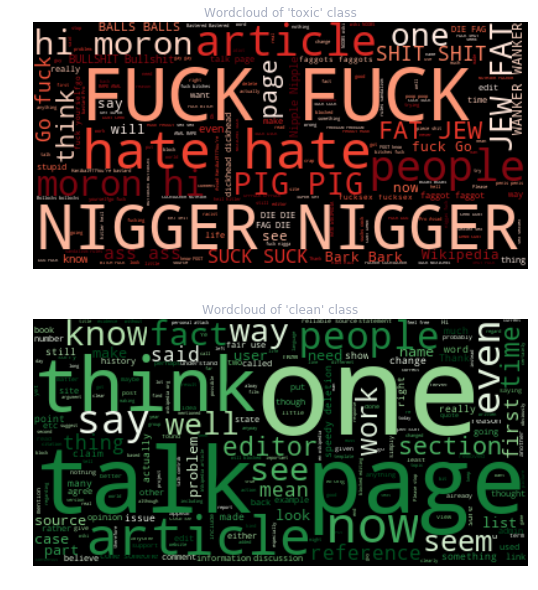

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Spam significance 

In [22]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

In [23]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers) ,'times more toxic spammers than clean ones!')

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [24]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> teabag! 

Teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, teabag, 

### Prepare data for model training

#####  Comments tokenizing

In [25]:
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [26]:
num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [27]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

In [28]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

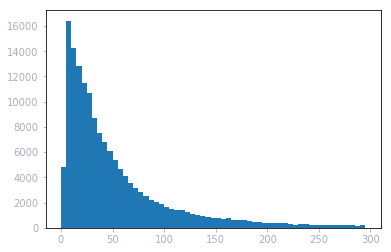

In [29]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [30]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  3

### Building the model

In [31]:
# Initialize all params used in both solutions of bulding the model
# Commented params are tuned by Grid Search
embedding_output_dim = 64
lstm_units = 100
# dropout_rate = 0.2 
dense_units = 50
n_classes = len(classes_names)

In [32]:
# Params for model training
batch_size = 64
epochs = 2

##### First version of model; Grid Search is not possible to execute with this solution
<font color="LIGHTSALMON">All cells from section below made raw ('R'); to enable them again, press 'Y' on each of them</font>

##### Tuning params with Grid Search

In [33]:
def create_model(dropout_rate=0.1):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=embedding_output_dim))
    model.add(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=0.2))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

dropout_rate = [0.2, 0.4]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

### Model training

In [35]:
X_train = fixed_sequences_train
y_train = labels_train

##### <font color="LIGHTSALMON">Classic training - not used, made raw ('R'); to enable them again, press 'Y'</font>

##### Training with Grid Search

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [44]:
print("Best params: %s (%f)" % (grid_result.best_params_, grid_result.best_score_))

Best params: {'dropout_rate': 0.2} (0.981812)


In [55]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params: %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params: {'dropout_rate': 0.2}
 Mean: (0.981812); Standard deviation: 0.000457

Set of params: {'dropout_rate': 0.4}
 Mean: (0.981774); Standard deviation: 0.000395


In [56]:
name_model_file = 'best-model-gridsearch.json'
name_weights_file = 'best-weights-gridsearch.h5'

def save_model_to_JSON(model):
    model_json = model.to_json()
    with open(f'{MODEL_PATH}{name_model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model to disk')
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Saved weights to disk')

def load_json_wih_weights_to_model():
    json_file = open(f'{MODEL_PATH}{name_model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Loaded model with weights from disk')
    return loaded_model

In [60]:
# Save model
best_model = grid_result.best_estimator_.model
save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)

Saved model to disk
Saved weights to disk


##### Predicting on test dataset and create submission file

In [61]:
X_test = fixed_sequences_test
y_test = best_model.predict([X_test], batch_size=1024)

In [62]:
sample_submission = pd.read_csv(f'{INPUT_PATH}sample_submission.csv')
sample_submission[classes_names] = y_test
sample_submission.to_csv(f'{SUBMISSION_PATH}submission.csv', index=False)

##### Manual model testing

In [63]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [69]:
single_comment = 'You are stupid!'
single_prediction = best_model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


Deteced class:  toxic 
Score:  99.06905889511108  %

 ¯\_(ツ)_/¯

All results:
       toxic severe_toxic   obscene   threat    insult identity_hate
0  0.990691     0.163332  0.847771  0.04154  0.709268      0.133639


##### <font color="#7affa0">TODO:</font>
- add plot of spammers classification based on variable spam_ratio
- try to use new features from EDA during model fitting
- execute SearchGrid of model's params
- try diffrent values of num_words (Tokenizer), maxlen (padding) (SearchGrid here not possible)
- <font color="green">✔</font> update Tensorflow to GPU version
- try diffrent architectures e.g. Pooling (Max -> Average), Early Stopping and Checkpoints (callbacks), Pretrained Embedding (Glove), LSTM with Bidirectional

##### <font color="#a07aff">Konsultacje:</font>
- Klasyfikacja dwupoziomowa: binarna (clean/toxic data) + wieloetykietowa (tylko toxic data); dwa klasyfikatory
- Dataset jest niezrównoważony (10/90); klasyfikacja niezrównoważona
- Oversampling (sprawdzić)
- Sprawdzić macierz pomyłek
- Klasyfikacja hierarchiczna (np. severe toxic zawsze jest toxic)
- <b>Zrobić przegląd literatury</b>